In [480]:
import pandas as pd
import numpy as np

#open CSV file and preparing data for normalizing
data = pd.read_csv('bodyPerformance.csv')

data.loc[(data['gender']=="M"),['gender']]=1
data.loc[(data['gender']=="F"),['gender']]=0

data.loc[(data['class']=="A" ),['class']]=0
data.loc[(data['class']=="B" ),['class']]=1
data.loc[(data['class']=="C" ),['class']]=2
data.loc[(data['class']=="D" ),['class']]=3


In [481]:
from sklearn.model_selection import train_test_split

#split data to 2 parts(train(75%)-test(25%))
features=data.drop('class',axis=1)
target=data['class']
X_train,X_test,Y_train,Y_test= train_test_split(features,target,test_size=0.25,random_state=2)
print(features.shape,X_train.shape,X_test.shape)

(13393, 11) (10044, 11) (3349, 11)


In [482]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
# Scale the data.
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
Y_train=np.array(Y_train,dtype=float)
Y_test=np.array(Y_test,dtype=float)

X_train: torch.Tensor = torch.from_numpy(X_train).float()
X_test: torch.Tensor = torch.from_numpy(X_test).float()
Y_train: torch.Tensor = torch.from_numpy(Y_train).long()
Y_test: torch.Tensor = torch.from_numpy(Y_test).long()

In [483]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd


import torch
class MLP(torch.nn.Module):
    def __init__(self, n_inputs, num_classes, dropout):
        super(MLP, self).__init__()
        self.hidden1 = torch.nn.Linear(n_inputs, 16)
        self.act1 = torch.nn.Tanh()
        self.hidden2 = torch.nn.Linear(16, 8)
        self.act2 = torch.nn.Tanh()
        self.hidden3 = torch.nn.Linear(8, 4)
        self.act3 = torch.nn.Tanh()
        self.hidden4 = torch.nn.Linear(4, 2)
        self.act4 = torch.nn.Tanh()
        self.output = torch.nn.Linear(2, num_classes)
        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.hidden4(X)
        X = self.act4(X)
        X = self.dropout(X)
        X = self.output(X)
        return X
model = MLP(11, 4, 0.2)

In [484]:
# Create a function to generate a population of neural network weights
def initialize_population(model,population_size):
    population = []
    for _ in range(population_size):
        individual = np.concatenate([param.detach().numpy().flatten() for param in model.parameters()])
        population.append(individual)
    return np.array(population)

In [485]:
def load_params(model, params):
    model_params = model.state_dict()
    model_params['hidden1.weight'] = torch.FloatTensor(params[:176].reshape(16, 11))
    model_params['hidden1.bias'] = torch.FloatTensor(params[176:192])
    model_params['hidden2.weight'] = torch.FloatTensor(params[192:320].reshape(8, 16))
    model_params['hidden2.bias'] = torch.FloatTensor(params[320:328])
    model_params['hidden3.weight'] = torch.FloatTensor(params[328:360].reshape(4, 8))
    model_params['hidden3.bias'] = torch.FloatTensor(params[360:364])
    model_params['hidden4.weight'] = torch.FloatTensor(params[364:372].reshape(2, 4))
    model_params['hidden4.bias'] = torch.FloatTensor(params[372:374])
    model_params['output.weight'] = torch.FloatTensor(params[374:382].reshape(4, 2))
    model_params['output.bias'] = torch.FloatTensor(params[382:386])
    model.load_state_dict(model_params)

In [486]:
# Define the loss function.
criterion = nn.CrossEntropyLoss()
#define fitness function
def fitness(individual,model, X_train, y_train):
    load_params(model, individual)
    model.eval()

    with torch.no_grad():
       outputs = model(X_train)
       loss = criterion(outputs, y_train)
       fitness = 1.0 / (loss.detach().item() + 1e-8)
    return fitness

In [487]:
# Define the crossover function
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1) - 1)
    child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
    return child1, child2

In [488]:
# Define the mutation function
def mutate(individual, mutation_rate=0.05):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.normal(0, 0.1)
    return individual


In [489]:
# Define the tournament selection function
def tournament_selection(population, fitness_scores, tournament_size=7):
    selected_indices = np.random.randint(0, len(population), tournament_size)
    selected_fitness = fitness_scores[selected_indices]
    winner_index = selected_indices[np.argmax(selected_fitness)]
    return population[winner_index]


In [509]:
# Define the genetic algorithm
generation_list=[]
best_fitness_list=[]
def genetic_algorithm(model, X_train, y_train):

    population_size=30
    generations=4000
    mutation_rate=0.05
    # Initialize population
    population = initialize_population(model, population_size)

    for generation in range(generations):
        # Evaluate fitness
        generation_list.append(generation)
        fitness_scores = np.array([fitness(ind, model, X_train, y_train) for ind in population])

        # Create new population
        new_population = []
        for _ in range(population_size // 2):
            parent1 = tournament_selection(population, fitness_scores)
            parent2 = tournament_selection(population, fitness_scores)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])

        population = np.array(new_population)

        # Print best fitness score in current generation
        best_fitness = np.max(fitness_scores)
        print(f"Generation {generation}: Best Fitness = {best_fitness}")
        best_fitness_list.append(best_fitness)
    # Return the best individual
    best_index = np.argmax(fitness_scores)
    return population[best_index]


In [491]:
best_solution=genetic_algorithm(model,X_train,Y_train)

Generation 0: Best Fitness = 0.6840512422782852
Generation 1: Best Fitness = 0.6900704870651756
Generation 2: Best Fitness = 0.6999903404729361
Generation 3: Best Fitness = 0.702334896790197
Generation 4: Best Fitness = 0.7029971707024889
Generation 5: Best Fitness = 0.7063592430905754
Generation 6: Best Fitness = 0.7075547624099051
Generation 7: Best Fitness = 0.7076045988807722
Generation 8: Best Fitness = 0.7084058098050188
Generation 9: Best Fitness = 0.7087957767132258
Generation 10: Best Fitness = 0.7119850568896932
Generation 11: Best Fitness = 0.7123086246822714
Generation 12: Best Fitness = 0.7128025837310935
Generation 13: Best Fitness = 0.7132885550878132
Generation 14: Best Fitness = 0.7137517469293724
Generation 15: Best Fitness = 0.7141504809050288
Generation 16: Best Fitness = 0.7146642288553668
Generation 17: Best Fitness = 0.7150300336894644
Generation 18: Best Fitness = 0.7163215931236907
Generation 19: Best Fitness = 0.7167067319993269
Generation 20: Best Fitness = 0

Text(0, 0.5, 'best fitness')

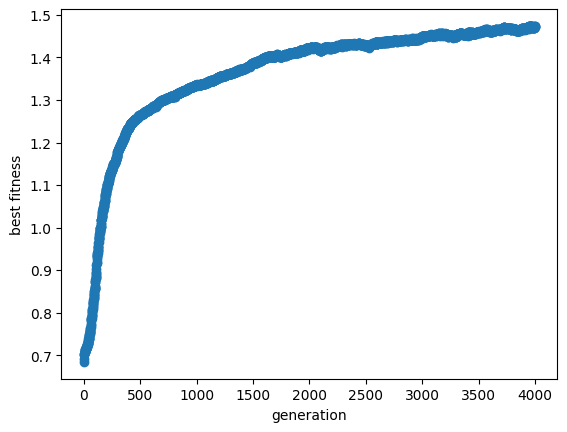

In [492]:
import matplotlib.pyplot as plt
plt.scatter(generation_list,best_fitness_list)
plt.plot(generation_list,best_fitness_list)
plt.xlabel("generation")
plt.ylabel("best fitness")

In [493]:
best_solution
load_params(model, best_solution)

In [494]:
# Create the 'models' directory.
from pathlib import Path

models_path = Path("models")
models_path.mkdir(exist_ok=True)
weights_path = models_path / "ga_weights.pth"
torch.save(model.state_dict(), weights_path)
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [495]:
def calculate_metrics(x: torch.Tensor, yt: torch.Tensor) -> None:
    # Calculate the crossentropy loss of the trained model.
    with torch.no_grad():
        preds = model(x)
        loss = criterion(preds, yt).item()
    print(f"Crossentropy : {loss}")
    # Calculate the classification accuracy for the trained model.
    acc = torch.mean((torch.argmax(preds, dim=1) == yt).float()).item()
    print(f"Accuracy : {acc}")


In [510]:
print("On the training set:")
calculate_metrics(X_train, Y_train)
print("On the testing set:")
calculate_metrics(X_test, Y_test)


On the training set:
Crossentropy : 0.6801661849021912
Accuracy : 0.7236160635948181
On the testing set:
Crossentropy : 0.7028286457061768
Accuracy : 0.7011048197746277


از جمله مزایای روش ژنتیک این می باشد که الگوریتم ژنتیک فضای گسترده تری از جواب ها را جستجو میکند این درحالی می باشد که الگوریتم گردینت فضای کوچک تر یا به عبارتی محلی تری را سرچ میکند.الگوریتم ژنتیک میتواند سریع تر از نقطه لوکال مینیما خارج شود اما ممکن هست در همان نقطه هم گیر بیفتد این درحالی هست که الگوریتم گردینت از این نقاط با شانس بیشتری خارج میشود اما مدت زمان طولانی تری را نیاز دارد تا از این نقاط فرار کند.الگوریتم ژنتیک نسبت به الگوریتم گردینت واکنش بهری به نویز و ناپیوستگی در داده ها از خود نشان میدهد.واز ظرفی این الگوریتم میتواند در محیط های موازی سازی اجرا شود.اما از معایب ان میتوان به زمان بر بودن این روش نسبت به الگوریتم گردینت و همچنین پیچیدگی پیاده سازی ان اشاره کرد.

روش هایی برای افزایش سرعت اجرای الگوریتم ژنتیک :میتوان به جای استفده از سی پی یو از جی پی یو استفاده کرد چرا که جی پی یو عملکرد بهتری در اجرای الگوریتم های هوش مصنوعی دارد.هرجایی که بتوان از وکتورایز کردن استفاده کرد بهتر هست این تکنیک را اعمال کنیم.بخش هایی از کد امکان موازی اجرا شدن دارند که با استفاده از یکسری از کتابخانه ها این امکان در اختیار ما قرار میگیرد.انتخاب مدل مناسب برای فیتنس فانکشن میتواند سرعت را خیلی بالاتر ببرد.از تکنیک هایی استفاده شود که هنگام همگرا شدن عملیات متوقف شود و یا هنگام گیر افتادن در نقاط لوکال مینیما یا ماکسیما محاسبات متوقف شوند.

In [502]:
train_preds = torch.argmax(model(X_train), dim=1)
test_preds = torch.argmax(model(X_test), dim=1)
train_preds_list = train_preds.tolist()
test_preds_list = test_preds.tolist()

true_AClass=0;
true_BClass=0;
true_CClass=0;
true_DClass=0;

for i in range(len(test_preds)):
  if(test_preds[i]==0):
    true_AClass+=1
  elif(test_preds[i]==1):
    true_BClass+=1
  elif(test_preds[i]==2):
    true_CClass+=1
  else:
    true_DClass+=1

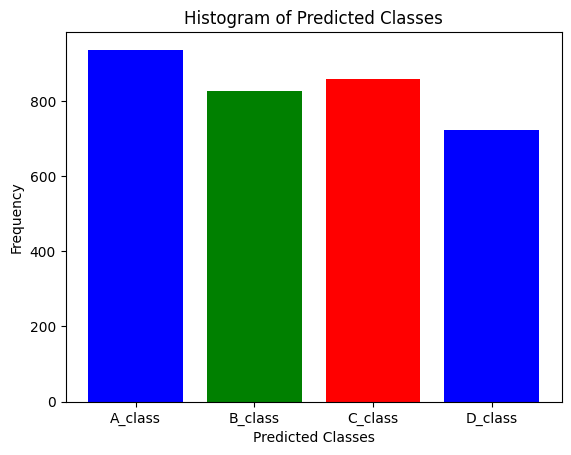

In [507]:
class_counts = [true_BClass, true_CClass, true_DClass]


y_labels = [true_AClass,true_BClass,true_CClass,true_DClass]
x_labels=['A_class','B_class','C_class','D_class']
plt.bar(x_labels,y_labels, color=['blue', 'green', 'red'])

plt.title('Histogram of Predicted Classes')
plt.xlabel('Predicted Classes')
plt.ylabel('Frequency')

plt.show()